In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
import seaborn as sns; sns.set_context("paper");sns.set()
from IPython.display import display
import glob
import sys
import joblib
sys.path.insert(-1,'../Tools')
from data_parser_new import parse
from data_modification import scale_at_patient


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

# Load Data

In [2]:
data_path = '../Data/'
patients = [
            parse(initial_path=data_path, patient_number=patient_no, at_map = True, verbose = False) 
        #for patient_no in [0]
        for patient_no in range(0,8)
]

In [3]:
patients = [scale_at_patient(patient, length=100) for patient in patients]

In [4]:
# Concatinate data
all_at = pd.concat([patient['at_maps'].add_prefix(patient['pt_id']+'_') for patient in patients],axis=1)
all_at.head()

,BiV7_001,BiV7_002,BiV7_003,BiV7_004,BiV7_005,BiV7_006,BiV7_007,BiV7_008,BiV7_009,BiV7_010,...,BiV5_172,BiV5_173,BiV5_174,BiV5_175,BiV5_176,BiV5_177,BiV5_178,BiV5_179,BiV5_180,BiV5_181
1,8.75,27.160494,52.777778,69.230769,28.75,62.162162,82.278481,31.818182,27.586207,33.707865,...,25.000000,26.168224,23.148148,50.458716,34.905660,41.666667,41.121495,41.284404,41.666667,18.691589
2,28.75,14.814815,34.722222,51.282051,52.50,81.081081,89.873418,25.000000,37.931034,51.685393,...,41.346154,25.233645,28.703704,58.715596,24.528302,55.555556,26.168224,36.697248,57.407407,25.233645
3,51.25,29.629630,19.444444,30.769231,71.25,81.081081,82.278481,32.954545,49.425287,65.168539,...,54.807692,24.299065,30.555556,54.128440,16.037736,57.407407,9.345794,24.770642,64.814815,32.710280
4,73.75,50.617284,34.722222,17.948718,88.75,89.189189,77.215190,51.136364,66.666667,80.898876,...,72.115385,39.252336,45.370370,57.798165,31.132075,65.740741,19.626168,31.192661,73.148148,49.532710
5,23.75,46.913580,75.000000,88.461538,10.00,35.135135,58.227848,45.454545,32.183908,22.471910,...,11.538462,34.579439,28.703704,38.532110,44.339623,26.851852,54.205607,46.788991,25.000000,26.168224


In [5]:
print(all_at.shape)
failed = all_at.columns[~all_at.any()]
print(failed)
all_at = all_at.drop(failed,axis=1,)
print(all_at.shape)
X_train = all_at.to_numpy().transpose()
print(X_train.shape)

(10705, 1420)
Index([], dtype='object')
(10705, 1420)
(1420, 10705)


In [6]:
# Run PCA
pca = PCA(n_components=20)
pca.fit(X_train) # fit trains the PCA
eigvals = pca.singular_values_
components = np.array(pca.components_)

ncomp = components.shape[0]
nfeat = components.shape[1]
print('Number of features: %d' %nfeat)
print('Number of components: %d' %ncomp)
print('Component matrix shape: (%d,%d)' %(ncomp,nfeat))

Number of features: 10705
Number of components: 20
Component matrix shape: (20,10705)


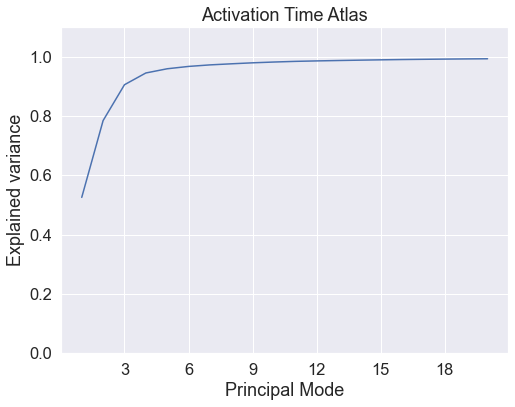

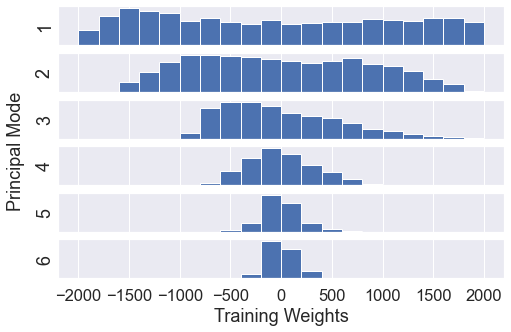

In [7]:
# Explained variance
sns.set(font_scale=1.5)
X_variance = np.cumsum(pca.explained_variance_ratio_)
component_number = np.arange(len(X_variance)) + 1

plt.figure(1,figsize=(8,6))
axes = plt.figure(1).gca()
axes.plot(component_number, X_variance)
axes.xaxis.set_major_locator(MaxNLocator(integer=True))
axes.set(ylim=(0,1.1),
            xlabel="Principal Mode", 
            ylabel="Explained variance",
            title="Activation Time Atlas");

# Component weights
X_weights = pca.transform(X_train)
nplots = ncomp
nplots = 6
fig, axes = plt.subplots(nplots, 1, figsize=(8,np.min([ncomp,5])), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(X_weights[:,i], 20, (-2000,2000)) # default: 10, (-20,20)
    ax.set_ylabel(i+1)
    ax.set_yticks([])
plt.xlabel('Training Weights');
plt.text(-2700,1300,'Principal Mode', rotation='vertical');

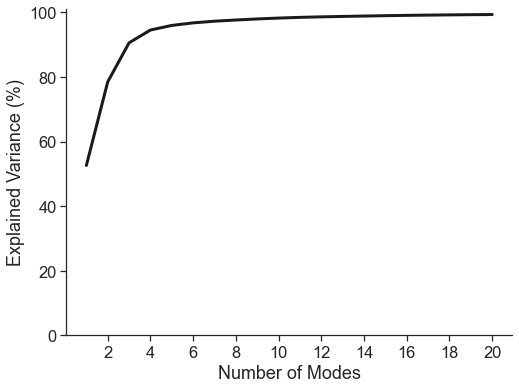

In [9]:
sns.set_style("ticks")

plt.figure(1,figsize=(8,6))
axes = plt.figure(1).gca()
axes.plot(component_number, X_variance*100, 'k',linewidth = 3)
axes.xaxis.set_major_locator(MaxNLocator(integer=True))
axes.xaxis.set_major_locator(ticker.MultipleLocator(2))
axes.set(ylim=(0,101),
            xlabel="Number of Modes", 
            ylabel="Explained Variance (%)");

sns.despine()
plt.savefig('Fig1A.pdf', transparent=True)

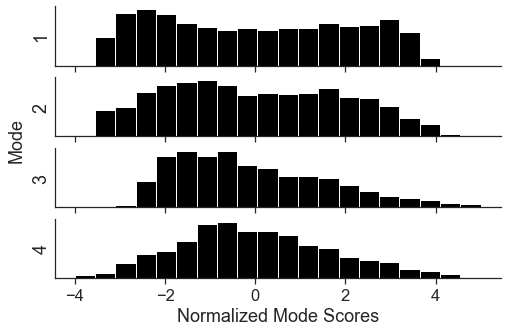

In [10]:
# Component weights
X_weights = pca.transform(X_train)
nplots = ncomp
nplots = 4

# normalize
for i in range(nplots):
    X_weights[:,i] = X_weights[:,i]/(np.absolute(X_weights[:,i]).std())


fig, axes = plt.subplots(nplots, 1, figsize=(8,np.min([ncomp,5])), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(X_weights[:,i], 20, (-4,5),color = "black") # default: 10, (-20,20)
    ax.set_ylabel(i+1)
    ax.set_yticks([])
plt.xlabel('Normalized Mode Scores');
plt.text(-5.5,340,'Mode', rotation='vertical');
sns.despine()
plt.savefig('Fig1C.pdf', transparent=True)

# Save off Atlas

In [ ]:
fname = 'AT_atlas_all.pickle'
#joblib.dump(pca,fname)

In [ ]:
fname = 'AT_atlas_all_weights.pickle'
#joblib.dump(X_weights,fname)

# Save off mode files

In [ ]:
fname = 'AT_atlas_mean.txt'
np.savetxt(fname,pca.mean_,fmt='%.2f')

In [ ]:
modes = [1,2,3,4,5,6,7,8]
percentiles = [5,95]

for m in modes:
    for p in percentiles:
        comps = [m-1]
        w = np.percentile(X_weights[:,m-1],p)
        AT = pca.mean_ + np.dot(w,components[comps])
        fname = 'AT_atlas_m%s_p%s.txt'%(m,p)
        print(fname)
        print(AT.min())
        print(AT.max())
        #np.savetxt(fname,AT,fmt='%.2f')

# Save off rescaled modes

In [ ]:
def normalize_rAT(AT):
    AT_norm = AT - AT.min() + 1
    AT_norm = AT_norm*100/AT_norm.max()
    
    return AT_norm

In [ ]:
modes = [1,2,3,4,5,6,7,8]
percentiles = [5,95]

for m in modes:
    for p in percentiles:
        comps = [m-1]
        w = np.percentile(X_weights[:,m-1],p)
        AT = pca.mean_ + np.dot(w,components[comps])
        AT = normalize_rAT(AT)
        fname = 'AT_atlas_m%s_p%s_norm.txt'%(m,p)
        print(fname)
        print(AT.min())
        print(AT.max())
        #np.savetxt(fname,AT,fmt='%.2f')

In [ ]:
fname = 'AT_atlas_mean_norm.txt'
mean_AT_norm = normalize_rAT(pca.mean_)
np.savetxt(fname,mean_AT_norm,fmt='%.2f')